# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
import progressbar       #will need to run 'pip install progressbar' from the terminal
import time


%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

In [2]:
#Test timing and progress bar function
import time
from tqdm import tqdm
from tqdm import tqdm_gui
for i in tqdm(range(10)):
    time.sleep(3)

100%|██████████| 10/10 [00:30<00:00,  3.00s/it]


In [3]:
# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [4]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

(array([ 578.,   76.,   27.,   10.,   11.,    4.,    5.,    1.,    0.,    2.]),
 array([   1. ,   94.6,  188.2,  281.8,  375.4,  469. ,  562.6,  656.2,
         749.8,  843.4,  937. ]),
 <a list of 10 Patch objects>)

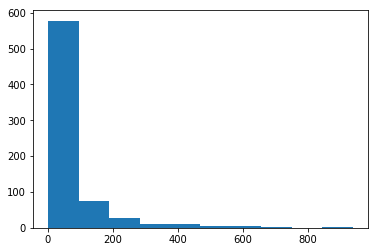

In [5]:
plt.hist(df['article_id'].value_counts(), bins=10)

In [6]:
# 50% of individuals have X or fewer article interactions: median_val
median_val = 3 

print('50% of individuals interact with {} number of articles or fewer'.format(median_val))

50% of individuals interact with 3 number of articles or fewer


In [7]:
# The maximum number of user-article interactions by any 1 user is: max_views_by_user: max_views_by_user
max_views_by_user_array = df['email'].value_counts()
max_views_by_user = max_views_by_user_array[0]
print('The maximum number of user-article interactions by any 1 user is: {}'.format(max_views_by_user))

The maximum number of user-article interactions by any 1 user is: 364


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [8]:
# Find and explore duplicate articles
# Remove any rows that have the same article_id - only keep the first
dup_rows = np.array(df_content[df_content['article_id'].duplicated()].index)

# Drop duplicate rows found
df_content.drop(dup_rows, inplace=True)
df_content.shape

(1051, 5)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [9]:
#a. The number of unique articles that have an interaction with a user: unique_articles
unique_articles = df['article_id'].value_counts().count()
print('Total number of unique articles that have at least one interaction: {}'.format(unique_articles))

Total number of unique articles that have at least one interaction: 714


In [10]:
#b. The number of unique articles in the dataset (whether they have any interactions or not): total_articles
total_articles = df_content['article_id'].value_counts().count()
print('Total number of unique articles on the IBM platform: {}'.format(total_articles))

Total number of unique articles on the IBM platform: 1051


In [11]:
#c. The number of unique users in the dataset. (excluding null values): unique_users
unique_users = df['email'].value_counts().count()
print('The number of unique users in the dataset is: {}'.format(unique_users))

The number of unique users in the dataset is: 5148


In [12]:
#d. The number of user-article interactions in the dataset: user_article_interactions
user_article_interactions = df.shape[0]
print('The total number of user-article interactions in the dataset is: {}'.format(user_article_interactions))

The total number of user-article interactions in the dataset is: 45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [13]:
# The most viewed article in the dataset as a string with one value following the decimal: most_viewed_article_id 
most_viewed_article_id = str(df['article_id'].value_counts().index[0])
print('The most viewed article in the dataset as a string: {}'.format(most_viewed_article_id))

The most viewed article in the dataset as a string: 1429.0


In [14]:
# The most viewed article in the dataset was viewed _____ times.`': max_views
max_views = np.array(df['article_id'].value_counts())[0]
print('The most viewed article in the dataset was viewed {} times'.format(max_views))

The most viewed article in the dataset was viewed 937 times


In [15]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [16]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [17]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_article_ids = []
    top_articles=[]
    
    if n > 0:
        try:
            top_article_ids = np.array(df['article_id'].value_counts().index)[:n]

            for i in top_article_ids:
                
                top_articles.append(df[df['article_id'] == i]['title'].values[0])
            
        except:
            pass
        
        
    return top_articles # Return the top article titles from df (not df_content)

In [18]:
def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_article_ids=[]
    
    if n > 0:
        try:
            top_article_ids = np.array(df['article_id'].value_counts().index)[:n]

        except:
            pass
    
    return top_article_ids # Return the top article ids

In [19]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[ 1429.  1330.  1431.  1427.  1364.  1314.  1293.  1170.  1162.  1304.]


In [20]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [ ]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''

    n_pairs = len(df['user_id'].values)

    cnter = 0
    bar = progressbar.ProgressBar(maxval=n_pairs+1, 
                                  widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    
        
    read_articles = df['article_id'].value_counts().index
    
    user_item = df.groupby(['user_id', 'article_id'])['title'].max().unstack()

    userid_list = user_item.index
    acticleId_list = user_item.columns

    user_item[acticleId_list] = 0      #reset all column entries to zero
    
    start=time.time()
    for i,j in zip(df['user_id'].values, df['article_id'].values):
        
        t1=time.time()
        if j in read_articles and user_item.loc[i, j] == 0:
#            print('Found item at: {} x {}'.format(i, j))
            # Update the progress bar
            cnter+=1 
            bar.update(cnter)
    
    #        print(i,j)
            user_item.loc[i, j] = 1
            t2=time.time()
#           print('   Time to add: {}'.format(t2-t1))
    
    bar.finish()
    finish=time.time()
    print('Total Run Time: {}'.format(finish-start))
    
    
    
    return user_item # return the user_item matrix 



In [ ]:
#Change type to 'Code' to run:

user_item = create_user_item_matrix(df)

In [ ]:
#Change type to 'Code' to run:

#Write previously compiled 'user_item' dataframe 
with open('user_item.p', 'wb') as handle:
    pickle.dump(user_item, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [21]:
# Load the user_item matrix here
user_item = pd.read_pickle('user_item_matrix.p')

In [23]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [24]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    user_content = np.array(user_item)
    dot_prod_users = user_content.dot(np.transpose(user_content))
    user_idx = np.where(user_item.index == user_id)[0][0]    

    # sort by similarity
    similar_idxs = np.argsort(dot_prod_users[user_idx])[::-1]    


    # remove user_id own user's id
    similar_idxs = similar_idxs[similar_idxs != user_id-1]

    #translate indices to users from df 
    most_similar_users = np.array(df.iloc[similar_idxs, ]['user_id'])
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [25]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [1117   20 1080   35  734    5  765   33 1180  103]
The 5 most similar users to user 3933 are: [   1   20 1080  734   35]
The 3 most similar users to user 46 are: [1180   20 1080]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [26]:
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [27]:
def get_article_names(article_ids, df=df, new_user=False):
    
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    new_user - (boolean) a flag to indicate if the user_id passed is new or existing

    '''
    article_names = []

    if len(article_ids) > 0:
        
        for id in article_ids:
            if type(id) is str:
                id = float(id)
            
            try:
    #            article_name = df[df['article_id'] == id]['title'].values[0]
                articles_df = pd.DataFrame(df.groupby(['article_id', 'title']).size().reset_index(name='Freq'))
                article_name = list(articles_df.loc[articles_df['article_id'] == id]['title'])[0]
                article_names.append(article_name)
            
            except:
                pass
                
    else:
        if not new_user:
            print('You need to provide at least one item for me to find an article!')
            
    return article_names # Return the article names associated with list of article ids



In [28]:
def get_user_articles(user_id, user_item=user_item, new_user=False):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    new_user - (boolean) a flag to indicate if the user_id passed is new or existing
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    article_ids = []
    article_names = []
    
    
    if not new_user:
        
        for id in article_ids:
            if type(id) is str:
                id = float(id)


#        article_ids = df[df['user_id'] == user_id]['article_id'].unique()
#        article_ids = list(map(str, article_ids))    
        article_ids = df[df['user_id'] == user_id]['article_id'].value_counts()
        article_ids = list(map(str, np.array(article_ids.index)))
        article_names = get_article_names(article_ids, new_user=new_user)    
   

    else:
        article_ids = get_top_article_ids(10)
        article_names = get_top_articles(10)

    return article_ids, article_names # return the ids and names

In [29]:
def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    recs_id = []
    recs = []
    common_ids = []
    count = 0
    
    #Get userid's closest neighbours ids and pull my own viewed articles
    similar_users = find_similar_users(user_id)
    my_article_ids, my_article_names = get_user_articles(user_id)


    #Loops through the users based on closeness to the input user_id
    #For each user - finds articles the user hasn't seen before and provides them as recs
    for user in similar_users[:]:

        if count < m:

            art_ids, art_names = get_user_articles(user)
            
            #Separate each article id in recommend list or already viewed list
            for idx in art_ids:

                #Check to see if article is already viewed or previously added to rec list arbitrarily
                if idx not in my_article_ids:
                    recs_id.append(idx)
             
            count = len(list(set(recs_id)))

    # Find only the uniques article ids after going thru all similar's articles or m recs found    
    recs_id = list(set(recs_id))
            

    return recs_id[:m] # return your recommendations for this user_id    

In [30]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['i am not a data scientist – ibm watson data lab',
 'some random weekend reading',
 'housing (2015): united states demographic measures',
 'using machine learning to predict parking difficulty',
 'use decision optimization to schedule league games',
 'use the cloudant-spark connector in python notebook',
 'predicting gentrification using longitudinal census data',
 'using github for project control in dsx',
 "a kaggler's guide to model stacking in practice",
 'self-service data preparation with ibm data refinery']

In [31]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [36]:
def get_article_interaction(user_id, df=df):
    '''
    INPUT:
    user_id - (int) user_id you want to find the total user-article interactions, including repeats
    df - (pandas dataframe) df as defined at the top of the notebook 
    
            
    OUTPUT:
    ttl_usr_interactions - (int) total user-article interactions from user-article interactions for any 
                                specific user_id passed. Return 0 interactions if user_id isn't found 
                                
    Other Details - helper function to assist in 'get_top_sorted_users' function when creating 
                    the neighbors_df dataframe.                                                               
    '''

    
    try:
        sort_article_df = pd.DataFrame(df['user_id'].value_counts())
        sort_article_idx = pd.DataFrame(df['user_id'].value_counts()).index
        sort_article_df['article_id'] = sort_article_idx
        sort_article_df.rename(columns={'user_id':'userid_count', 'article_id': 'user_id'}, inplace=True)
        ttl_usr_interactions = sort_article_df.loc[user_id]['userid_count']
        
    except:
        ttl_usr_interactions=0

    return int(ttl_usr_interactions)

In [37]:
def get_top_sorted_users(user_id, df=df, user_item=user_item, new_user=False):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    new_user - (boolean) a flag to indicate if the user_id passed is new or existing
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - number of articles viewed by neighbor_id, excluding already viewed by user_id
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''

    neighbors_dict = {'neighbor_id': [], 
                      'similarity': [],
                      'num_interactions': [],
                      'rec_ids': []}
        



    #Check if user_id exists
#    if user_id in user_item.index:
    if not new_user:
                
        #Create the dot-product matrix for all article similarities
        user_content = np.array(user_item)
        dot_prod_users = user_content.dot(np.transpose(user_content))

    
        #Get similarity dot-product neighbor ids sorted by most common articles viewed by user_id
        user_idx = np.where(user_item.index == user_id)[0][0]
        neighbors_array = dot_prod_users[user_idx]

        
    else:
        #Since no existing user we will pass sum of all userid-item interaction and sort by index
        neighbors_array = np.array(user_item.sum(axis=1))

    #=========================================================
        
    neighbor_id = np.argsort(neighbors_array)[::-1]+1 #add 1 since this is array index to get userid

    #Get userid articles to use for comparison with neighbors
    #Will return empty lists if this is a new user
    my_article_ids, my_article_names = get_user_articles(user_id, new_user=new_user)



    #Loops through the users which is sorted by closeness to the input user_id
    #Get all user articles skipping the first user which would be the target userid
    for user in neighbor_id[:50]:

        rec_ids = []

        #Get article stats for each neighbor
        art_ids, art_names = get_user_articles(user, new_user=False)

        #Find the number of common articles from dot-product array by user index
        common_articles = neighbors_array[user-1]

        #Make a Similiarity metric for each neighbor user
        #Get the total articles in user_item matrix, should be 714
        #Take the size of common_ids and divide by total articles to get a 'similarity percentage'
        similiarity_percent = round(common_articles/neighbors_array.max()*100,2)
        ttl_usr_interactions = get_article_interaction(user)

        #Filter out of total articles any from target user_id previously viewed
        rec_ids = [x for x in art_ids if x not in my_article_ids]


        #print('For user: {:>5}, total articles: {:>3}, unique common articles: {:>4}, similiarity: {:>5}%'.format(user, len(ttl_ids), len(rec_ids), similiarity_percent))

        #Insert into Neighbor dictionary
        neighbors_dict['neighbor_id'].append(user)
        neighbors_dict['similarity'].append(similiarity_percent)
        neighbors_dict['num_interactions'].append(ttl_usr_interactions)
        neighbors_dict['rec_ids'].append(rec_ids)        


    #Convert the compiled dictionary to dataframe
    neighbors_df = pd.DataFrame({'neighbor_id': neighbors_dict['neighbor_id'], 
                                 'similarity %': neighbors_dict['similarity'], 
                                 'num_interactions': neighbors_dict['num_interactions'],
                                 'rec_ids' : neighbors_dict['rec_ids']})

        
    #=========================================================

    if not new_user:
    
        #Sort dataframe by similarity and number of interactions, remove first row which is always target userid
        neighbors_df = neighbors_df.sort_values(['similarity %', 'num_interactions'])[::-1][1:]


    else:
        #Sort dataframe by similarity and number of interactions, remove first row which is always target userid
        neighbors_df = neighbors_df.sort_values(['num_interactions'])[::-1]
    
    
    return neighbors_df # Return the dataframe specified in the doc_string

In [38]:
def user_user_recs_part2(user_id, m=10, new_user=False):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    '''
    
    recs = []
    rec_names = []

    # Get similar userids neighbor dataframe
    # Here we will choose the users that have the most total article interactions    
    neighbors_df = get_top_sorted_users(user_id, new_user=new_user)
    
    neighbors_users = np.array(neighbors_df['neighbor_id'])
    
    # Loops through the users based on closeness to the input user_id
    # For each user - finds articles the user hasn't seen before and provides them as recs
    # Does this until m recommendations are found

    
    #Choose articles with the articles with the most total interactions before choosing 
    #those with fewer total interactions. We have already sorted neighbors_df by interactions
    #And we already captured unique articles not previously view in 'rec_ids' column
    #So once we locate the user in neighbors_users we just get first 'rec_ids' articl                

    for ii, user in enumerate(neighbors_users):

        if len(set(recs)) < m:

            if not new_user:
                try:
                    recs.append(neighbors_df.loc[neighbors_df['neighbor_id'] == user]['rec_ids'].values[0][0])
                except:
                    pass
                    
            #only taking the top ranked article based on user-article interactions    
            else:

                #recs.append(neighbors_df.iloc[ii]['rec_ids'][0])
                recs = get_top_article_ids(m)
                m+=1
    
    recs = list(set(map(str, recs)))
    rec_names = get_article_names(recs)


    return recs, rec_names

In [39]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1170.0', '1274.0', '1314.0', '1293.0', '1402.0', '1330.0', '1186.0', '609.0', '1400.0', '1427.0']

The top 10 recommendations for user 20 are the following article names:
['apache spark lab, part 1: basic concepts', 'data model with streaming analytics and python', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'uci: adult - predict income', 'insights from new york car accident reports', 'connect to db2 warehouse on cloud and db2 using scala', 'simple linear regression? do it the bayesian way', 'uci ml repository: chronic kidney disease data set', 'use xgboost, scikit-learn & ibm watson machine learning apis']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [40]:
#The user that is most similar to user 1:
get_top_sorted_users(1).head(1)

,neighbor_id,similarity %,num_interactions,rec_ids
1,3933,97.22,45,[]


In [41]:
#The user that is the 10th most similar to user 131:
get_top_sorted_users(131).head(10)

,neighbor_id,similarity %,num_interactions,rec_ids
1,3870,98.67,144,[195.0]
2,3782,52.00,363,"[43.0, 29.0, 1172.0, 1330.0, 1305.0, 943.0, 48..."
3,23,50.67,364,"[29.0, 43.0, 1172.0, 1305.0, 1330.0, 943.0, 21..."
5,203,44.00,160,"[241.0, 1396.0, 1060.0, 1298.0, 32.0, 1056.0, ..."
4,4459,44.00,158,"[1060.0, 1396.0, 241.0, 510.0, 428.0, 1061.0, ..."
6,98,38.67,170,"[1175.0, 1274.0, 116.0, 164.0, 730.0, 1324.0, ..."
7,3764,38.67,169,"[1175.0, 1274.0, 116.0, 164.0, 51.0, 651.0, 73..."
9,49,38.67,147,"[1274.0, 681.0, 936.0, 1393.0, 1330.0, 1337.0,..."
8,3697,38.67,145,"[1274.0, 681.0, 936.0, 1393.0, 1337.0, 315.0, ..."
10,242,33.33,148,"[1170.0, 1172.0, 1437.0, 1183.0, 109.0, 1391.0..."


In [42]:
### Tests with a dictionary of results

user1_most_sim = 3933 # Find the user that is most similar to user 1 
user131_10th_sim = 242 # Find the 10th most similar user to user 131

In [43]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Answer**: Neither function (user_user_recs or user_user_recs_part2) would be able to return any recommendations because both are relying on the user_id passed in to find and return an ordered list of neighbours. To improve our functions to accommodate a non existing user_id passed in, we could add part of our 'find neighbors' function to just return a dataframe with top articles sorted by most reads/viewed and just take the 'm' from the top of the list as the recommendations.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [44]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = list(map(str, get_top_article_ids(10)))
new_user_recs

['1429.0',
 '1330.0',
 '1431.0',
 '1427.0',
 '1364.0',
 '1314.0',
 '1293.0',
 '1170.0',
 '1162.0',
 '1304.0']

In [45]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [46]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [47]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [48]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [49]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [50]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)

In [51]:
u.shape

(5149, 5149)

In [52]:
s.shape

(714,)

In [49]:
vt.shape

(714, 714)

**Question:** "Explain why we can use SVD in this situation above and why it is different than in the lesson?"

**Answer.**: In the lesson we used FunkSVD because we needed to deal with NaN values in a sparse user-item matrix. The matrix used in the lesson was a little more complex as it dealt with ratings and here with our 'user-article' matrix we are only using for a user '1' for interactions and '0' for no interaction to any particular article. Since this is simple, ie. either a 1 or 0 we have our matrix in a sense filled with no NaNs. And in this case we can use straightforward SVD because we are 'NaN free'.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

In [53]:
def acc_vs_latentfeat_graph(user_item_df = user_item, latent_feats = 710):
    
    num_latent_feats = np.arange(10,latent_feats,20)
    sum_errs = []

    u, s, vt = np.linalg.svd(user_item_df)
    
    
    for k in num_latent_feats:
        # restructure with k latent features
        s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]

        # take dot product
        user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))

        # compute error for each prediction to actual value
        diffs = np.subtract(user_item_df, user_item_est)

        # total errors and keep track of them
        err = np.sum(np.sum(np.abs(diffs)))
        sum_errs.append(err)


    plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
    #plt.plot(num_latent_feats, 1 - np.array(sum_errs)/diffs.shape[0]);
    plt.xlabel('Number of Latent Features');
    plt.ylabel('Accuracy');
    plt.title('Accuracy vs. Number of Latent Features');

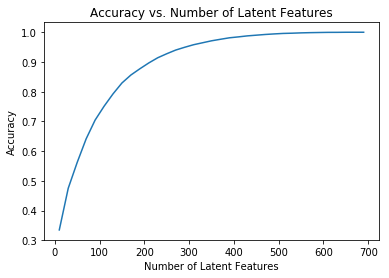

In [54]:
acc_vs_latentfeat_graph(user_item)

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [55]:
df_train = df.head(40000)
df_test = df.tail(5993)

In [ ]:
def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''

    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = user_item_test.index
    test_arts = user_item_test.columns
    
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)


#Write previously compiled 'user_item' dataframe so we don't have to recompile these assets in th future
with open('user_item_train.p', 'wb') as handle:
    pickle.dump(user_item_train, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('user_item_test.p', 'wb') as handle:
    pickle.dump(user_item_test, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

with open('test_idx.p', 'wb') as handle:
    pickle.dump(test_idx, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('test_arts.p', 'wb') as handle:
    pickle.dump(test_arts, handle, protocol=pickle.HIGHEST_PROTOCOL)




In [56]:
# Load the user_item_train matrix here
user_item_train = pd.read_pickle('user_item_train.p')

# Load the user_item test here
user_item_test = pd.read_pickle('user_item_test.p')

In [57]:
user_item_train.head(10)

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
9,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
user_item_test.head(10)

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1432.0,1433.0,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1443.0
user_id,,,,,,,,,,,,,,,,,,,,,
2917,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3024,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3093,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3193,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3527,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3532,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3684,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3740,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3777,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
#Recreating these dataframe so I don't have to rerun the "create_test_and_train_user_item" function
df_train = df.head(40000)
df_test = df.tail(5993)
test_idx = user_item_test.index
test_arts = user_item_test.columns
test_idx.shape, test_arts.shape

((682,), (574,))

In [60]:
#How many users can we make predictions for in the test set?': 
#This will be the user ids that we can find in the test data that are in the train data set

users_pred_in_test = np.intersect1d(df_train['user_id'].unique(),df_test['user_id'].unique())
print('Total articles we can make predictions that are in the test set: {}'.format(len(users_pred_in_test)))

Total articles we can make predictions that are in the test set: 20


In [61]:
#How many users in the test set are we not able to make predictions for because of the cold start problem?':
#This will be the user ids that we can find in the train data that are NOT in the test data set

users_in_test = df_test['user_id'].unique()
users_not_pred_in_test = len(users_in_test) - len(users_pred_in_test)
print('Total users we cannot make predictions b/c of cold-start problem: {}'.format(users_not_pred_in_test))

Total users we cannot make predictions b/c of cold-start problem: 662


In [62]:
#How many articles can we make predictions for in the test set?':
#This will be the articles ids that we can find in the test data that are in the train data set

articles_pred_in_test = np.intersect1d(df_train['article_id'].unique(),df_test['article_id'].unique())
print('Total articles we can make predictions that are in the test set: {}'.format(len(articles_pred_in_test)))

Total articles we can make predictions that are in the test set: 574


In [63]:
#How many articles in the test set are we not able to make predictions for because of the cold start problem?':

articles_in_test = df_test['article_id'].unique()
articles_not_pred_in_test = len(articles_in_test) - len(articles_pred_in_test)
print('Total articles we cannot make predictions b/c of cold-start problem: {}'.format(articles_not_pred_in_test))

Total articles we cannot make predictions b/c of cold-start problem: 0


In [64]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [65]:
# Now, let's see how well we can use the training decomposition to predict on test data

#### Step 1: Find common userids and articles in both train and test datasets

In [66]:
#We already computed the userids and articles in the testing set from above, look at shape
test_idx.shape, test_arts.shape

((682,), (574,))

In [67]:
#Strip off the training rows as userid, and training columns as articles
train_idx = user_item_train.index
train_arts = user_item_train.columns
train_idx.shape, train_arts.shape

((4487,), (714,))

In [68]:
#Find the intersection of userids and articles in both testing and training indices 
test_user_subset = np.intersect1d(test_idx,train_idx)
test_arts_subset = np.intersect1d(test_arts,train_arts)
test_user_subset.shape, test_arts_subset.shape

((20,), (574,))

In [69]:
#Since train_idx & arts are by index, locate where those indices are for the specific userids & articles
train_indexes = np.where(np.in1d(train_idx, test_user_subset))[0]
train_articles = np.where(np.in1d(train_arts, test_arts_subset))[0]
train_indexes.shape, train_articles.shape

((20,), (574,))

In [70]:
# Do the same for test_idx, locate where the indices are our common test user set falls on
test_indexes = np.where(np.in1d(test_idx, test_user_subset))[0]

#### Step 2: Prepare the Training model 

In [71]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train =  np.linalg.svd(user_item_train)
u_train.shape, s_train.shape, vt_train.shape

((4487, 4487), (714,), (714, 714))

In [72]:
#Filter the item_user test and train matrices to only the shared test_user and test_arts subsets
# Now that we have their indices we can simply locate them

user_item_test_reduce = user_item_test.iloc[test_indexes,:]
user_item_train_reduce = user_item_train.iloc[train_indexes, train_articles]

user_item_test_reduce.shape, user_item_train_reduce.shape

((20, 574), (20, 574))

#### Step 3: Build out the Testing model

In [85]:
#For our latent features we will choose at max of 570 based on our user_item column limit of 574

num_latent_feats = np.arange(10,570,10)
test_sum_errs = []
train_sum_errs = []
all_errs=[]

for k in num_latent_feats:
    
    # restructure with k latent features
    u_train_k, s_train_k, vt_train_k = u_train[:, :k], np.diag(s_train[:k]), vt_train[:k, :]

    u_test_k, vt_test_k = u_train_k[train_indexes,:] , vt_train_k[:,train_articles]  #training on s_train_k
    
    # take dot product
    
    user_item_train_preds = np.around(np.dot(np.dot(u_train_k, s_train_k), vt_train_k))
    user_item_test_preds = np.around(np.dot(np.dot(u_test_k, s_train_k), vt_test_k))

    
    # compute error for each prediction to actual value
    test_diffs = np.subtract(user_item_test_reduce, user_item_test_preds)
    train_diffs = np.subtract(user_item_train, user_item_train_preds)

    

    u_i_test_dims = user_item_test.shape[0]*user_item_test.shape[1]
    u_i_train_dims = user_item_train.shape[0]*user_item_train.shape[1]


    # total errors and keep track of them
    test_err = np.sum(np.sum(np.abs(test_diffs)))
    test_sum_errs.append(test_err)

    train_err = np.sum(np.sum(np.abs(train_diffs)))
    train_sum_errs.append(train_err)

    all_errs.append(1-((np.sum(user_item_test_preds)+
                        np.sum(np.sum(user_item_test)))/u_i_test_dims))


Let's plot them separately so we can see all the details of each graph:

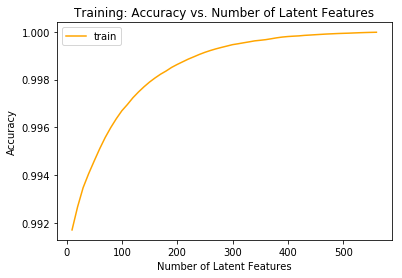

In [86]:
plt.plot(num_latent_feats, 1 - np.array(train_sum_errs)/u_i_train_dims, label='train', color='orange');
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Training: Accuracy vs. Number of Latent Features');
plt.legend();

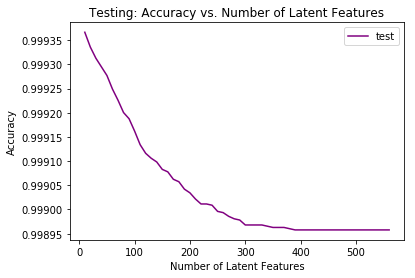

In [87]:
plt.plot(num_latent_feats, 1 - np.array(test_sum_errs)/u_i_test_dims, label='test', color='purple');
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Testing: Accuracy vs. Number of Latent Features');
plt.legend();

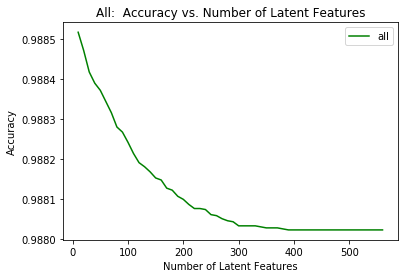

In [88]:
plt.plot(num_latent_feats, all_errs, label='all', color='green');    
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('All:  Accuracy vs. Number of Latent Features');
plt.legend();

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Result Comments of SVD Train-Test**

It is clear the accuracy curve for the testing is almost a constant just below 1 while our training curve goes on asymptotically out. This might suggest that our model train might be overfitting and makes predictions too well on the testing data. Seems like while our model produces great results on training data it doesn't seem to generalize too well on the testing data. On these findings I would try to keep the latent features down to a minimum as it would seem to reduce the computation expense vs. the addition accuracy we are gaining. 

As for using this as a recommender system, I was say it not good on its own as we only have a few users in our train-test subset and our user-item matrix is very sparse. And also the sparsness of the matrix could be why our accuracy is so high in training as it doesn't take many latent features to reproduce the original matrix.

**How to Improve Our Results**

While we didn't get the best results from our train and test of SVD, we could use this as bases to improve on how we go about improving our efforts to finding a best recommendation system. For example, if we combined the above with a ranked based system in some sort of A/B testing. This could be outlined as cookie based split invariant metric of our two groups. The 'A group' would see matrix factorized system and the 'B group' would see the ranked system which might contain features like clicks on articles, browsing time or heat map options. These would be the variant metrics of our test. The null hypothesis in this case would be there is no difference in the metrics observed. Once we verified our invariant metric (cookies) is spliting the group evenly then we would move on to evaluating the variant metrics. By checking on each metrics if they are 'statistically' significant we can make a decision if we continue to move our system into production or not.

In [89]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0